In [12]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import random
import os
from sklearn.model_selection import train_test_split
path='D:/DS/Hackathons/Kaggle/Digit recogonizer/'
os.chdir(path)

In [13]:
#Import Train data and split the target and features
filename='train.csv'
X_train=pd.read_csv(filename)
y_train=pd.get_dummies(X_train['label'])
X_train.drop('label',axis=1,inplace=True)
X_train=np.array(X_train.values)
y_train=np.array(y_train.values)
test_filename='test.csv'
X_test=pd.read_csv(test_filename)
X_test=np.array(X_test.values)
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
print(X_train.shape)

(42000, 784)


In [14]:
#get the dimension of the image and # classes
seed = 128
rng = np.random.RandomState(seed)
img_flat=X_train.shape[1]
img_size=int(np.sqrt(X_train.shape[1]))
m=X_train.shape[0]
index_list=list(range(0,m))
print('image size:',str((img_size,img_size)))
print('training data:',str(m))

image size: (28, 28)
training data: 42000


In [15]:
# Network Parameters
learning_rate = 0.001
n_epochs = 10
batch_size = 64
num_input = X_train.shape[1]
num_classes = 10

[0 0 0 0 0 0 0 1 0 0]


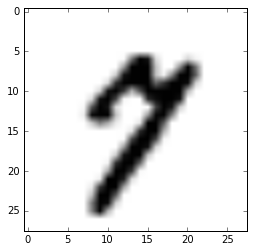

In [16]:
#Visualize the input image of the numpy array
i=504
img_array=X_train[i,:]
print(y_train[i,:])
img_2d=np.reshape(img_array,(img_size,img_size))
plt.imshow(img_2d, cmap='binary')
plt.show()

In [18]:
#placeholder for training data
X = tf.placeholder(tf.float32, [None, img_flat],name='X')
Y = tf.placeholder(tf.float32, [None, num_classes],name='Y')
#y_true_cls = tf.placeholder(tf.int64, [None])
keep_rate = 0.8
# Reshape input to a 4D tensor 
x = tf.reshape(X, shape=[-1, 28, 28, 1])
# Convolution Layer, using our function

conv1 = tf.layers.conv2d(
      inputs=x,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
dropout = tf.layers.dropout(inputs=dense, rate=0.4)
logits = tf.layers.dense(inputs=dropout, units=10)
y_pred_cls = tf.argmax(logits, axis=1)
y_pred=tf.nn.softmax(logits)
loss = tf.losses.softmax_cross_entropy(logits=logits,onehot_labels=Y)
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
init = tf.global_variables_initializer()

In [20]:
def batch_data(x, y, batch_size):
    shuffle = np.random.permutation(len(x))
    start = 0
    x = x[shuffle]
    y = y[shuffle]
    while start + batch_size <= len(x):
        yield x[start:start+batch_size], y[start:start+batch_size]
        start += batch_size
    

In [21]:
prediction=[]
start=0
batch_size=100
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(init)
    for i in range(n_epochs): # train the model n_epochs times
        for batch_i, (source_batch, target_batch) in enumerate(batch_data(X_train, y_train, batch_size)):
            _, loss_val =sess.run([optimizer,loss], feed_dict={X: source_batch, Y:target_batch}) 
        #if i%10==0:
        print ('epoch:',str(i),'loss = ' + str(loss_val))
    print('Optimization Finished!')
    savePath = saver.save(sess, path+'my_model.ckpt')

epoch: 0 loss = 0.106419
epoch: 1 loss = 0.0787396
epoch: 2 loss = 0.0176567
epoch: 3 loss = 0.00860818
epoch: 4 loss = 0.00309149
epoch: 5 loss = 0.0429696
epoch: 6 loss = 0.00135344
epoch: 7 loss = 0.00423888
epoch: 8 loss = 0.0233942
epoch: 9 loss = 0.000625527
Optimization Finished!


In [24]:
#Prediction:
with tf.Session() as sess:
    saver.restore(sess, path+'my_model.ckpt')
    graph = tf.get_default_graph()
    while start + batch_size <= len(X_test):
        X_batch=X_test[start:start+batch_size]
        pred = sess.run(y_pred_cls, feed_dict={X:X_batch})
        prediction.extend(pred)
        start+=batch_size
    output=pd.DataFrame({'ImageId':range(1,28001),'Label':prediction})
    output.to_csv('output.csv',index=False)
    print(pred[0])

INFO:tensorflow:Restoring parameters from D:/DS/Hackathons/Kaggle/Digit recogonizer/my_model.ckpt
2
